<a href="https://colab.research.google.com/github/AlexandraVallet/fenicslectures/blob/main/Solution_Braindiffusion5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion of tracer in the brain

The purpose of this notebook is to learn how to solve the diffusion equation using the finite element computing tool FEniCS. Then we propose to apply this knowledge to interpret clinical data of transport and clearance of tracer in human brain.

# I/ Sleep deprivation effect on tracer transport and clearance in the human brain

By the end of this notebook, we will perform simulations of tracer diffusion in the brain to interpret data from this paper :

Sleep deprivation impairs molecular clearance from the human brain,
Per Kristian Eide, Vegard Vinje, Are Hugo Pripp, Kent-Andre Mardal, Geir Ringstad,
Brain, Volume 144, Issue 3, March 2021, Pages 863–874, https://doi.org/10.1093/brain/awaa443

![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/brain_enrichment.png?raw=1)


Abstract : "It remains an enigma why human beings spend one-third of their life asleep. Experimental data suggest that sleep is required for
clearance of waste products from brain metabolism. This has, however, never been verified in humans. The primary aim of the pre-
sent study was to examine in vivo whether one night of total sleep deprivation affects molecular clearance from the human brain.
Secondarily, we examined whether clearance was affected by subsequent sleep. Multiphase MRI with standardized T1 sequences
was performed up to 48 h after intrathecal administration of the contrast agent gadobutrol (0.5 ml of 1 mmol/ml), which served as
a tracer molecule. Using FreeSurfer software, we quantified tracer enrichment within 85 brain regions as percentage change from
baseline of normalized T1 signals. The cerebral tracer enrichment was compared between two cohorts of individuals; one cohort
(n = 7) underwent total sleep deprivation from Day 1 to Day 2 (sleep deprivation group) while an age and gender-matched control
group (n = 17; sleep group) was allowed free sleep from Day 1 to Day 2. From Day 2 to 3 all individuals were allowed free sleep.
The tracer enriched the brains of the two groups similarly. Sleep deprivation was the sole intervention. One night of sleep depriv-
ation impaired clearance of the tracer substance from most brain regions, including the cerebral cortex, white matter and limbic
structures, as demonstrated on the morning of Day 2 after intervention (sleep deprivation/sleep). Moreover, the impaired cerebral
clearance in the sleep deprivation group was not compensated by subsequent sleep from Day 2 to 3. The present results provide
in vivo evidence that one night of total sleep deprivation impairs molecular clearance from the human brain, and that humans do
not catch up on lost sleep. "


# II/  Diffusion equation 

We consider the diffusion of the concentration c of a chemical solute (here the Gadobustrol tracer), as a function of the position x. 
Experimentally it is known that the flux of this quantity, ie the amount of the quantify crossing a unit area per time, is given by the relation
$$ F = - k \nabla c $$ with k the diffusivity. 
We note hee the minus sign, as the diffusion flux is directed toward the regions of lower concentration. 

## Time dependant equation

The diffusion equation for the concentration is then given by 
$$\frac{\partial c}{\partial t}= - k \Delta c + S(x) $$
where $S(x)$ is a source term.

## Steady state

In the case of a steady problem, we obtain a Laplace problem : 

\begin{alignat}{2}
-\Delta c &= f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
\partial_n u &= g \quad && \text{ on } \Gamma_{\mathrm{N}}
\end{alignat}

with $f=S(x)/k$, $u_{\mathrm{D}}$ a Dirichlet boundary condition and $ g$ a Neumann boundary condition.

Let's try to resolve this equation using FEniCS !


# III/ Solve the steady problem with FEniCS 

For hints and more reading on how to solve the Poisson problem in FEniCS, see the [section on the Poisson problem](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Creating the computing environment

### Importing FEniCS
The first thing we need to do is to import `FEniCS` and the meshing library `mshr`.

In [1]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics



E: Package 'python-software-properties' has no installation candidate
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/fenic

In [ ]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import dolfin
    import mshr
else:
    try:
        import dolfin
        import mshr
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import dolfin
        import mshr

### Initializing notebook plotting options


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 

### Importing other libraries



In [ ]:
import numpy as np
from math import sqrt

## Creating the mesh

We are now ready to set up our problem solving. We start with the geometry. Let create a mesh for square domain with a circular hole in the middle.

To create the mesh, we use boolean operators from `mshr`. 

Define one square and a circle, then combine them with operators :
- `+` (union), 
- `*` (intersection),
- `-` (set difference). 

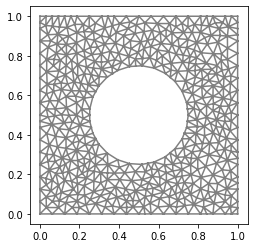

In [ ]:
S0 = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(1, 1))
C0 = mshr.Circle(dolfin.Point(0.5,0.5),0.25)
domain = S0-C0
mesh = mshr.generate_mesh(domain,20)
dolfin.plot(mesh)

## Defining the finite element function space
Once the mesh is created, we can define the finite element function space $V$. We will use a standard piecewise linear $P_1$ function space.

In [ ]:
V = dolfin.FunctionSpace(mesh,'P',1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


## Defining the boundary condition
The boundaries can be defines using a condition of distance. 

In [ ]:
def circle(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    # The inner boundary is defined to be on the boudary and at a distance smaller that the radius 0.3 
    return on_boundary and (d0 < 0.3)



The outer boundary 


In [ ]:
def outside(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    # The outer boundary is defined to be on the boudary and at a distance larger that the radius 0.3
    return on_boundary and (d0 > 0.3)

The Dirichlet boundary condition 

$$ u = u_{\mathrm{D}} \quad  \text{ on } \Gamma_{\mathrm{D}} $$

is defined using the dolfin built in function `DirichletBC`.

We decide to impose c=0 on the inner circle boundary

In [ ]:
bc = dolfin.DirichletBC(V, 0 , circle)

The Neumann boundary condition

$$\partial_n u = g \quad  \text{ on } \Gamma_{\mathrm{N}} $$

will appear directly in the weak form of the equations.

## Defining the variational problem
The finite element variational problem for the Poisson equation reads: 

Find $u \in V$ such that
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x 
$$


We have 
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x =\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s
$$


By definition of the finite element function space $v=0$ on $\Gamma_D$, thus

$$ - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s = - \int_{\partial\Omega} gv \,\mathrm{d}s $$

he resulting weak form of our problem reads


$$
\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x +\int_{\partial\Omega} gv \,\mathrm{d}s
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x+\int_{\partial\Omega} gv \,\mathrm{d}s.
\end{align}

And the problem is to solve 

$$a(u, v)= L(v)$$ 

We first define the trial and test function using the built in functions

In [2]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

NameError: ignored

Then, we define the source term as a gaussian function

In [3]:
f = dolfin.Expression('exp(-10.0*(pow(x[0]-0.5,2) + pow(x[1] - 0.5,2)))',degree = 2)

NameError: ignored

We define an outer flow boundary condition (Neumann) which will be applied on all the boundaries where no Dirichlet condition is defined.


In [ ]:
g=dolfin.Constant(1)

The bilinear form a and the linea form L are defined as follow :

In [ ]:
a = dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx
L = f*v*dolfin.dx + g*v*dolfin.ds

The ds variable implies a boundary integral, while dx implies an integral over the domain Ω.

The integration $ds$ is carried out over the entire boundary, including the Dirichlet boundary. However, since the test function v vanishes on the Dirichlet boundary (as a result specifying a `DirichletBC`), the integral will only include the contribution from the Neumann boundary.

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. 

In [4]:
c = dolfin.Function(V)
dolfin.solve(a == L, c, bc)


NameError: ignored

The dolfin `plot` function can be used to visualize the solution. 

In [ ]:
dolfin.plot(c)

## Postprocessing

We can integrate the value of c over the entire domain using the dolfin function `assemble`

In [5]:
integral=dolfin.assemble(c*dolfin.dx(mesh))

print('Total mass :',integral)

NameError: ignored

# IV/ Solve the time dependant problem with FEniCS

We now consider the time dependant problem governed by the diffusion equation 

$$\frac{\partial c}{\partial t}= -k\Delta c + S(x)$$

## Time discretisation 

We discretize the time derivative with a finite difference approximation.


Let superscript $n$ denote a quantity at time $t_n$, where $n$ is an integer counting the time steps of length $\Delta t$. The time derivative can be discretized by

$$ \frac{\partial c}{\partial t}^{n+1}= \frac{c^{n+1}-c^{n}}{\Delta t}$$

Then, using an implicit backward Euler scheme, the diffusion equation at time step $n+1$ is

$$ \frac{c^{n+1}-c^{n}}{\Delta t}=-k\Delta c^{n+1} + S(x)^{n+1}$$

The solution of c at time step $n+1$ is obtained by solving the stationary problem 

$$ c^{n+1}+k\Delta c^{n+1} \Delta t - S(x)^{n+1} \Delta t - c^n =0$$


## Variational form 

Let u be the solution $c^{n+1}$. 



We multiply by a test function v and integrate second-derivatives by parts and use the divergence theorem. This lead to the bilinear and linear forms

\begin{align}
  a(u, v) &= \int_{\Omega} (uv + k\Delta t \nabla u \cdot \nabla v ) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega}  (S(x)^{n+1} \Delta t + c^{n} ) v  \,\mathrm{d}x+\int_{\partial \Omega} g^{n+1}\Delta t v \,\mathrm{d}s
\end{align}





In [ ]:
# for the exemple we set a time step 
dt=1
# a uniform previous solution at previous time step
u_n=dolfin.interpolate(dolfin.Constant(0),V)
# a uniform source term
S=dolfin.interpolate(dolfin.Constant(0),V)
# a diffusion coefficient
k=1


F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx + dt*g*v*dolfin.ds
a, L = dolfin.lhs(F), dolfin.rhs(F)

## Initial conditions

Let define the initial conditions. For the example we use a gaussian-like function. 


In [6]:
x=np.linspace(0,1,100) 
y=np.linspace(0,1,100)

X,Y =np.meshgrid(x, y)

x0=0.5 
y0=0.5 
sx=0.5 
sy=0.5
A=1

Z=A-A*np.exp(-((X-x0)**2/(2*sx**2) + (Y - y0)**2)/(2*sy**2))

plt.contourf(X,Y,Z,50)


NameError: ignored

In the dolfin syntax (similar to C) this function is defined as

In [7]:
cinit=dolfin.Expression('A-A*exp(-((pow(x[0]-x0,2)/(2*pow(sx,2)))+(pow(x[1]-y0,2)/(2*pow(sy,2)))))', A=1,x0=0.5,y0=0.5,sx=0.5,sy=0.5,degree = 2)

NameError: ignored

We interpolate the initial function on the finite element space. This is out solution at initial time. 

In [ ]:
u_n = dolfin.interpolate(cinit, V)

## Source term definition

We set the source term as a homogeneous sink term. 





In [8]:
S=dolfin.Constant(-1)

NameError: ignored

## Resolution 

Finaly we solve the problem over several time steps



In [9]:
t = 0
num_steps=5

dt=0.1



k=1

u_n = dolfin.interpolate(cinit, V)

plt.figure()
dolfin.plot(u_n)




# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]

for n in range(num_steps):

    # Update current time
    t += dt

    # We update the problem

    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V) 

    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (c_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)

    c = dolfin.Function(V)


    # Solve variational problem
    dolfin.solve(a == L, c,bc)

    # Update previous solution
    c_n.assign(c)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)

    plt.figure()
    dolfin.plot(c)


NameError: ignored

Let visualize the evolution of the integrated mass with time :

In [10]:
spantime=np.linspace(0,dt*num_steps,num_steps+1)
plt.plot(spantime,spanmass)
plt.ylabel('Mass')
plt.xlabel('Time')

NameError: ignored

# V/ Simulation of the Gadobustrol experiments

Now the objective (exercice) is to apply the previous computing framework (solving the time dependant diffusion equation) in order to interpret the clinical data presented in section I/. You will need to adapt the previous code in order to set up a proper mesh, diffusion coefficient, source term and boundary conditions.

Here are some hints :

- Typical size of the human brain : 15 cm
- Gadobustrol apparent diffusion coefficient : 1.5 × 10−5 cm2/s


## Enrichment phase

Assuming the concentration is 100 (arbitrary unit) in the subarachnoid space after injection. What is the profile of concentration in the brain after 6 hours ?


## Clearance phase

From the previous concentration profile, we would like to compute the clearance. 

The clearance of Gadobustrol is done through the cerebrospinal fluid transport and absorption out of the central nervous system (into the veins or the lynphatic vessels). We can make two simple different assumption about the clearance 
- clearance is homogeneous over the whole brain (absorption through capillaries) 
- clearance occurs on the outersurface (absorption from the subarachnoid space)

In order to get an estimate of the clearance rate, we can have in mind that :
- The total CSF turn-over rate has been estimated to 500 ml/day in humans

Can you simulate the clearance phase ? 

How does the diffusion coefficient impact this clearance ? Can we make the assumption that this coefficient is different during sleep and awake phases ?


Note : We recomand to work in the CGS unit system (cm, gram, second)

# VI / proposition of a solution 

There is not a unique way to interpret the data. Research is about making clear hypothesis and discuss the meaning of our model.

## Brain mesh

We assume the brain as an homogeneous hollow sphere and we decine to model a 2D cut of it. The geometry is therefor a 2D disk. The outer surface (subarachnoid boundary) is assumed to have a radius of 8 cm. The inner surface (ventricule) is assumed to have a radius of 2 cm. 

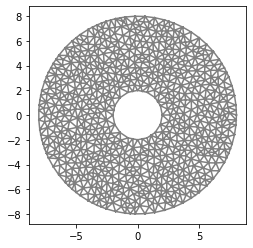

In [ ]:
S0 = mshr.Circle(dolfin.Point(0.,0.),8)
C0 = mshr.Circle(dolfin.Point(0.,0.),2)
domain = S0-C0
mesh = mshr.generate_mesh(domain,20)
dolfin.plot(mesh)

Finite elements function spaces (we use the same as previously)

In [ ]:
V = dolfin.FunctionSpace(mesh,'P',1)

## Enrichment phase

### Boundary conditions

We define the inner and outer boundaries using a distance condition.

In [ ]:
def inner(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0)**2 + (x[1]-0)**2)
    #condition 
    return on_boundary and (d0 < 3)


def outer(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0)**2 + (x[1]-0)**2)
    #condition 
    return on_boundary and (d0 > 3)

We assume that during the enrichment phase, the tracer is saturated in the subarachnoid space. The concentration is assumed as constant on the outer boundary and we impose a Dirichlet boundary condition.

In [ ]:
# Dirichlet boundary condition on the outer side
bc = dolfin.DirichletBC(V, dolfin.Constant(1) , outer)

On the inner side we assume a no flow Neumann boundary condition

In [ ]:
g=dolfin.Constant(0) # flow condition on Neumann boundaries

### Initial conditions

At time t=0 h , we assume no tracer is in the brain. The concentration is set to 0.

In [ ]:
t = 0
c_n = dolfin.interpolate(dolfin.Constant(0), V)

### Parameters

We define the apparent diffusion coefficient for Gadobustrol in the brain.

In [ ]:
k=1.5e-5 #cm2/s

### Time stepping definition 

We would like to simulate the evolution of tracer diffusion over 6 hours. We chose the number of time step and compute the corresponding lenght of time step.

In [ ]:
tend= 60*60*6  
nsteps=100
dt=tend/nsteps


### Time resolution of enrichment phase

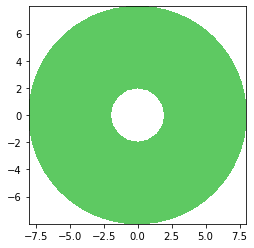

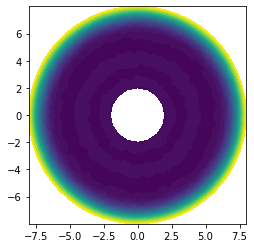

In [ ]:
# Let plot the initial state 

plt.figure()
dolfin.plot(c_n)

# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt
   
    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)
    S=-dolfin.Constant(0) # uniform source term
    g=dolfin.Constant(0) # flow condition on Neumann boundaries
    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (c_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    c = dolfin.Function(V)
    dolfin.solve(a == L, c,bc)

    # Update previous solution
    c_n.assign(c)

    #add the mass to the list
    mass=dolfin.assemble(c_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(c)

We can see that after 6 hours, the tracer only entered the outer surface of the brain. This is very similar to what is seen on the MRI data.





![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/brain_enrichment.png?raw=1)



Let plot the evolution of the integral of concentration on the whole domain over time.

Text(0.5, 0, 'Time (h)')

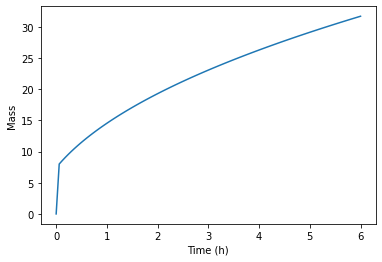

In [ ]:
# We normalise the results by the max .
maxmass=spanmass[-1]
plt.plot(np.array(spantime)/60/60,spanmass/maxmass*100)
plt.ylabel('Mass normalised (%)')
plt.xlabel('Time (h)')

We store the results for further plotting in the following.

In [ ]:
c6h=dolfin.interpolate(c_n, V)
t6h=tend
spantime6h=spantime
spanmass6h=spanmass

## Clearance phase


### Source term 
Lets now simulate the clearance phase. We assume a uniform source term, define to be proportional to 
$$ Q_{CSF}/V_{brain} \times c_n$$
with $V_{brain}$ the volume of the brain, $Q_{CSF}$ the absorption rate of CSF in humans. The source term will therefor be updated at each time step. 

In [ ]:
brainvol=4/3*3.14*8**3-4/3*3.14*2**3
brainsurf=4*3.14*8**2

QCSF=500/(60*60*24)



### Boundary conditions 

As we are in the scenario when absorption of the CSF occurs homogeneously within the brain, we assume a no flow boundary condition on the outer part (subarachnoid space).





In [ ]:
g=dolfin.Constant(0) # flow condition on Neumann boundaries

On the inner part (ventricles) we assume that the tracer concentration is neglectable and use a Dirichlet boundary condition with $c=0$.

In [ ]:
bc = dolfin.DirichletBC(V, dolfin.Constant(0) , inner)

### Initial condition 

The initial condition correspond to the profile of concentration we computed at t=6 hours. 

In [ ]:
c_n = dolfin.interpolate(c6h, V)

### Time stepping

In [ ]:
# We now start simulation at 6 hours.
t = t6h

tend=60*60*48 # seconds

num_steps=100

dt=(tend-t)/num_steps

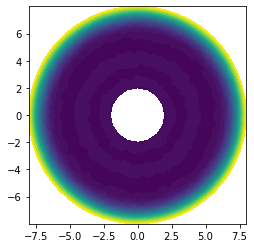

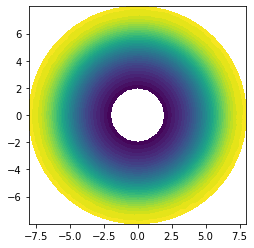

In [ ]:
plt.figure()
dolfin.plot(u_n)

# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt

    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # option 1 : uniform CSF absorption within the brain
    S=-u_n*QCSF/brainvol*4  #  source term we chose a factor 4 here to get results close to the data

    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (c_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    c = dolfin.Function(V)
    dolfin.solve(a == L, c,bc)

    # Update previous solution
    c_n.assign(c)

    #add the mass to the list
    mass=dolfin.assemble(c_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(c)

After 48 hours, the concentration profile is more homogeneous that at 6 hours. Tracer are now present in half of the brain. This is similar to what we can see on MRI data.

![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/brain_enrichment.png?raw=1)

In [ ]:
#save results
spanmassk0=spanmass

### Change of permeability

Let redo the clearance phase simulation using another diffusion coefficient. The apparent difffusion can be indeed modified by several physiological factors like the change of the astrocyte size and consequently of the extracellular space volume or the change of the pulsation of the vessel walls. Both phenomena were reported to occur during sleep. To see the effect of such a change of the apparent diffusion, we use a factor 10. We will apply this enhacement factor during 8 hours between 10h and 18h after the injection of tracer to mimic a change of physiology during one night.

In [ ]:
# save the original diffusion coefficient
k0=k
# choose an enhancement factor
enhancement_factor=10


### Time resolution of the clearance phase with modified apparend diffusion coefficient

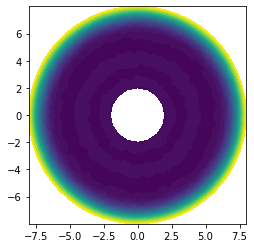

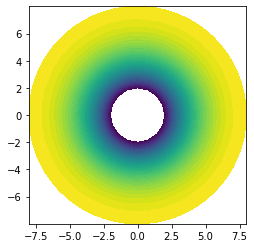

In [ ]:
plt.figure()
dolfin.plot(c_n)

# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt

    # set the apparent diffusion value
    if (t>= 60*60*10)&(t<= 60*60*18):
      k=k0*enhancement_factor
    else :
      k=k0

    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # option 1
    S=-u_n*QCSF/brainvol*4 #  source term
    g=dolfin.Constant(0) # flow condition on Neumann boundaries


    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (c_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    c = dolfin.Function(V)
    dolfin.solve(a == L, c,bc)

    # Update previous solution
    c_n.assign(c)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(c)

### Time evolution of total tracer mass
Let compare the time evolution of tracer accumulatio in the brain with the measurement. 

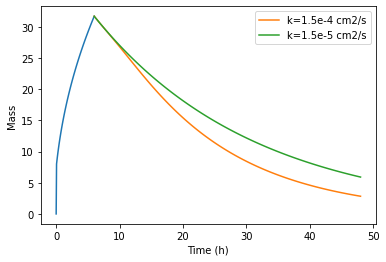

In [ ]:
# compare the two simulations
plt.plot(np.array(spantime6h)/60/60,spanmass6h)
plt.plot(np.array(spantime)/60/60,spanmass, label='k=k_0 x 10 during the night')
plt.plot(np.array(spantime)/60/60,spanmassk0, label='k=k_0')
plt.ylabel('Mass')
plt.xlabel('Time (h)')
plt.legend()

We can clearly see that the tracer is cleared more efficiently in the case of increased apparent diffusion during the night. We can compare the curves of our prediction with the actual measurment on MRI : 

![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/tracer_time.png?raw=1)

Using our simple diffusion model, we can interpret the data by changing the apparent diffusion. This allow us to provide an hypothesis about the effect of sleep of brain clearance : 
*" During sleep, the apparent diffusion is increased by a factor superior to 10 that enhance the clearance of solute".*

This hypothesis would need to be validated by further experiments. 


There is not a unique way to interpret the results of this paper. All we can do so far is to test hypothesis with our computational model. 

This is one of the **strengh of the in silico biomechanical models** : we can prepare in vivo experiments by performing preliminary in silico experiements to test the effects of several hypothesis. This is much less costly, provide physical insight on the processes, and from an ethical point of view, it do not involve invasive procedure on humans or animals.